<a href="https://colab.research.google.com/github/dernameistegal/airbnb_price/blob/main/plot_gradient_boosting_regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd


# Gradient Boosting regression

This example demonstrates Gradient Boosting to produce a predictive
model from an ensemble of weak predictive models. Gradient boosting can be used
for regression and classification problems. Here, we will train a model to
tackle a diabetes regression task. We will obtain the results from
:class:`~sklearn.ensemble.GradientBoostingRegressor` with least squares loss
and 500 regression trees of depth 4.

Note: For larger datasets (n_samples >= 10000), please refer to
:class:`~sklearn.ensemble.HistGradientBoostingRegressor`.


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
listings =pd.read_pickle("/content/drive/MyDrive/Colab/airbnb/data/data1/listings_workfile.pickle")

In [4]:
# Author: Peter Prettenhofer <peter.prettenhofer@gmail.com>
#         Maria Telenczuk <https://github.com/maikia>
#         Katrina Ni <https://github.com/nilichen>
#
# License: BSD 3 clause

import matplotlib.pyplot as plt
import numpy as np
from sklearn import datasets, ensemble
from sklearn.inspection import permutation_importance
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

## Load the data

First we need to load the data.



In [5]:
y = listings["log_price"]
X = listings[listings.columns.difference(["price", "log_price"])] 
columns1 = set(X.columns)
X = X.select_dtypes([np.number])
columns2 = set(X.columns)
columns1 - columns2

{'description_en', 'host_about_en', 'lang', 'name_en', 'reviews'}

## Data preprocessing

Next, we will split our dataset to use 90% for training and leave the rest
for testing. We will also set the regression model parameters. You can play
with these parameters to see how the results change.

`n_estimators` : the number of boosting stages that will be performed.
Later, we will plot deviance against boosting iterations.

`max_depth` : limits the number of nodes in the tree.
The best value depends on the interaction of the input variables.

`min_samples_split` : the minimum number of samples required to split an
internal node.

`learning_rate` : how much the contribution of each tree will shrink.

`loss` : loss function to optimize. The least squares function is  used in
this case however, there are many other options (see
:class:`~sklearn.ensemble.GradientBoostingRegressor` ).



In [12]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=13
)

params = {
    "n_estimators": 10000,
    "max_depth": 5,
    "min_samples_split": 5,
    "learning_rate": 0.01,
    "loss": "squared_error",
}

In [13]:
# Baseline performance
mean_prediction = np.mean(y_train)

mse = mean_squared_error(y_test, np.ones(len(y_test)) * mean_prediction)
print("The root mean squared error (MSE) on test set: {:.4f}".format(np.sqrt(mse)))

The root mean squared error (MSE) on test set: 0.6776


## Fit regression model

Now we will initiate the gradient boosting regressors and fit it with our
training data. Let's also look and the mean squared error on the test data.



In [14]:
reg = ensemble.GradientBoostingRegressor(**params)
reg.fit(X_train, y_train)

mse = mean_squared_error(y_test, reg.predict(X_test))
print("The root mean squared error (MSE) on test set: {:.4f}".format(np.sqrt(mse)))

The root mean squared error (MSE) on test set: 0.3912


## Plot training deviance

Finally, we will visualize the results. To do that we will first compute the
test set deviance and then plot it against boosting iterations.



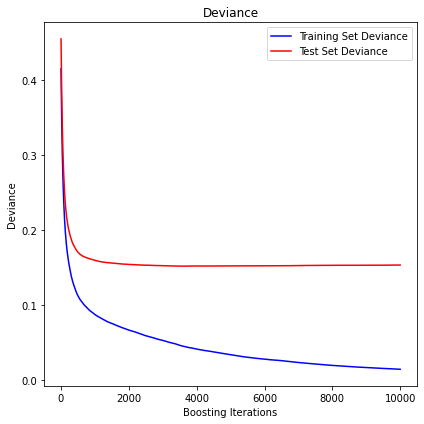

In [15]:
test_score = np.zeros((params["n_estimators"],), dtype=np.float64)
for i, y_pred in enumerate(reg.staged_predict(X_test)):
    test_score[i] = reg.loss_(y_test, y_pred)

fig = plt.figure(figsize=(6, 6))
plt.subplot(1, 1, 1)
plt.title("Deviance")
plt.plot(
    np.arange(params["n_estimators"]) + 1,
    reg.train_score_,
    "b-",
    label="Training Set Deviance",
)
plt.plot(
    np.arange(params["n_estimators"]) + 1, test_score, "r-", label="Test Set Deviance"
)
plt.legend(loc="upper right")
plt.xlabel("Boosting Iterations")
plt.ylabel("Deviance")
fig.tight_layout()
plt.show()

## Plot feature importance

<div class="alert alert-danger"><h4>Warning</h4><p>Careful, impurity-based feature importances can be misleading for
   **high cardinality** features (many unique values). As an alternative,
   the permutation importances of ``reg`` can be computed on a
   held out test set. See `permutation_importance` for more details.</p></div>

For this example, the impurity-based and permutation methods identify the
same 2 strongly predictive features but not in the same order. The third most
predictive feature, "bp", is also the same for the 2 methods. The remaining
features are less predictive and the error bars of the permutation plot
show that they overlap with 0.



/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 154 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 138 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 159 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 154 missing from current font.
  font.set_text(s, 0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 138 missing from current font.
  font.set_text(s, 0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 159 missing from current font.
  font.set_text(s, 0, flags

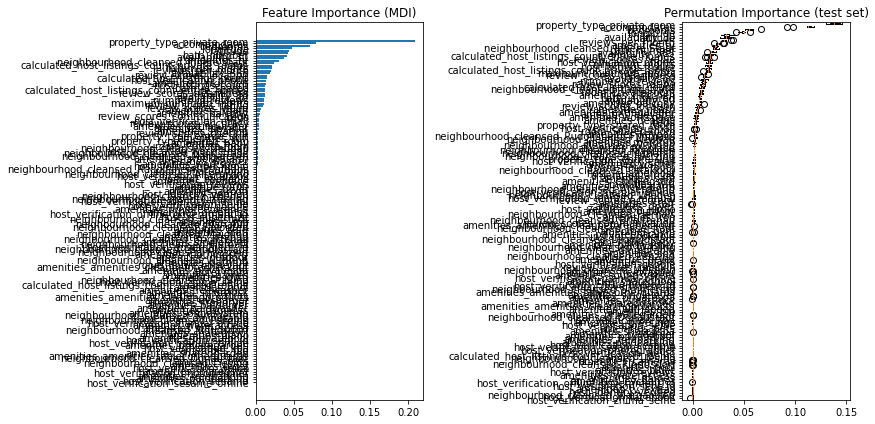

In [16]:
feature_importance = reg.feature_importances_
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + 0.5
fig = plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.barh(pos, feature_importance[sorted_idx], align="center")
plt.yticks(pos, np.array(X.columns)[sorted_idx])
plt.title("Feature Importance (MDI)")

result = permutation_importance(
    reg, X_test, y_test, n_repeats=10, random_state=42, n_jobs=2
)
sorted_idx2 = result.importances_mean.argsort()
plt.subplot(1, 2, 2)
plt.boxplot(
    result.importances[sorted_idx2].T,
    vert=False,
    labels=np.array(X.columns)[sorted_idx2],
)
plt.title("Permutation Importance (test set)")
fig.tight_layout()
plt.show()

In [17]:
#variable feature importance
pd.DataFrame(np.array([X.columns[sorted_idx2[::-1]], feature_importance[sorted_idx2[::-1]], result.importances_mean[sorted_idx2[::-1]]]).T)[:30]

,0,1,2
0,property_type_private_room,0.209331,0.138345
1,accommodates,0.079694,0.110569
2,bedrooms,0.071606,0.056597
3,longitude,0.047299,0.049003
4,availability_30,0.040984,0.033157
5,latitude,0.043471,0.032694
6,reviews_per_month,0.020739,0.031883
7,amenities_tv,0.03726,0.0258
8,neighbourhood_cleansed_Innere Stadt,0.030001,0.02191
9,bath_number,0.04174,0.021622
